<a href="https://colab.research.google.com/github/MigXDev/CS_Datos_I_DESAFIO_3/blob/main/TelecomX_LATAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challengue Alura - TelecomX

## 🛠️ Preparación de los Datos



### Importacion de Bibliotecas

In [50]:
# Importación de librerías esenciales
import pandas as pd # Manipulación de datos
import numpy as np # Manipulación de datos

import matplotlib.pyplot as plt # Visualización de Datos
import seaborn as sns # Visualización de Datos

# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Modelos que se utilizarán más adelante
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Advertencias (para limpiar outputs si es necesario)
import warnings
warnings.filterwarnings("ignore")

### Extracción del Archivo Tratado

Carga el archivo CSV que contiene los datos tratados anteriormente.<br>

*   📂 Atención: Utiliza el mismo archivo que limpiaste y organizaste en la Parte 1 del desafío Telecom X. Debe contener solo las columnas relevantes, ya con los datos corregidos y estandarizados.

#### Carga y exploración del dataset

Comenzamos cargando la base de datos ya tratada. Se trata de un dataset de clientes de una empresa de telecomunicaciones. El objetivo será predecir si un cliente abandonará el servicio (`abandono_cliente`) en base a sus características.

A continuación se realiza una primera inspección.


In [51]:
Datos = '/content/TelecomX_Data_Base.csv'

In [52]:
# Cargamos el archivo CSV procesado
Df_base = pd.read_csv('/content/TelecomX_Data_Base.csv', sep=';')

# Visualizamos las primera fila
Df_base.head(1)

,id_cliente,abandono_cliente,genero,jubilado,pareja,dependientes,meses_antiguedad,servicio_telefono,ad.multiples_lineas,servicio_internet,...,ad.proteccion_dispositivo,ad.soporte_tecnico,tv.streaming,peliculas.streaming,contrato,factura_digital,metodo_pago,cargo.diario,cargo.mensual,cargo.total
0,0002-ORFBO,No,Femenino,False,Si,Si,9,Si,No,DSL,...,No,Si,Si,No,Un año,Si,Cheque por correo,2.16,65.6,593.3


#### Inspección estructural

In [53]:
# Exploramos descripción estadística de variables numéricas
Df_base.describe()

,meses_antiguedad,cargo.diario,cargo.mensual,cargo.total
count,7267.000000,7267.000000,7267.000000,7267.000000
mean,32.346498,2.127771,64.720098,2277.182035
std,24.571773,0.990534,30.129572,2268.648587
min,0.000000,0.600000,18.250000,0.000000
25%,9.000000,1.165000,35.425000,396.200000
50%,29.000000,2.310000,70.300000,1389.200000
75%,55.000000,2.955000,89.875000,3778.525000
max,72.000000,3.900000,118.750000,8684.800000


In [54]:
# Exploración básica
print(f"Filas: {Df_base.shape[0]}, Columnas: {Df_base.shape[1]}")
print(f"\nTipos de datos:\n{Df_base.dtypes.value_counts()}")
print(f"\nValores faltantes:\n{Df_base.isnull().sum()}")

Filas: 7267, Columnas: 22

Tipos de datos:
object     17
float64     3
bool        1
int64       1
Name: count, dtype: int64

Valores faltantes:
id_cliente                   0
abandono_cliente             0
genero                       0
jubilado                     0
pareja                       0
dependientes                 0
meses_antiguedad             0
servicio_telefono            0
ad.multiples_lineas          0
servicio_internet            0
ad.seguridad_online          0
ad.respaldo_online           0
ad.proteccion_dispositivo    0
ad.soporte_tecnico           0
tv.streaming                 0
peliculas.streaming          0
contrato                     0
factura_digital              0
metodo_pago                  0
cargo.diario                 0
cargo.mensual                0
cargo.total                  0
dtype: int64


#### Análisis Univariado (EDA)

##### Analisis numerico

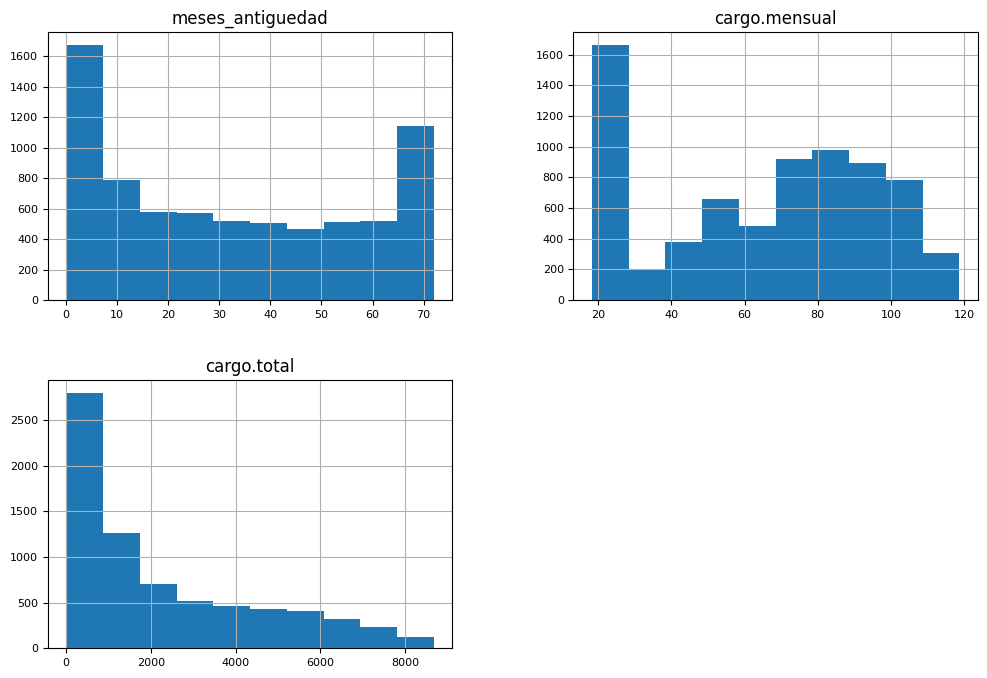

In [55]:
# Análisis numéricas
num_cols = ['meses_antiguedad', 'cargo.mensual', "cargo.total"]
Df_base[num_cols].hist(figsize=(12, 8), xlabelsize=8, ylabelsize=8);

##### Analisis categorico

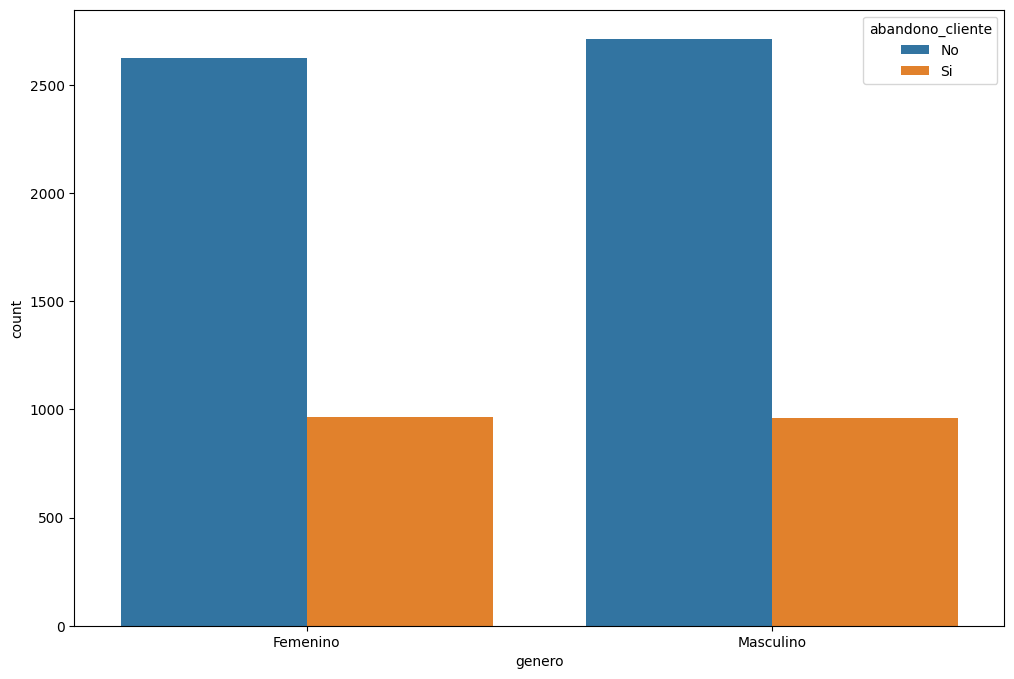

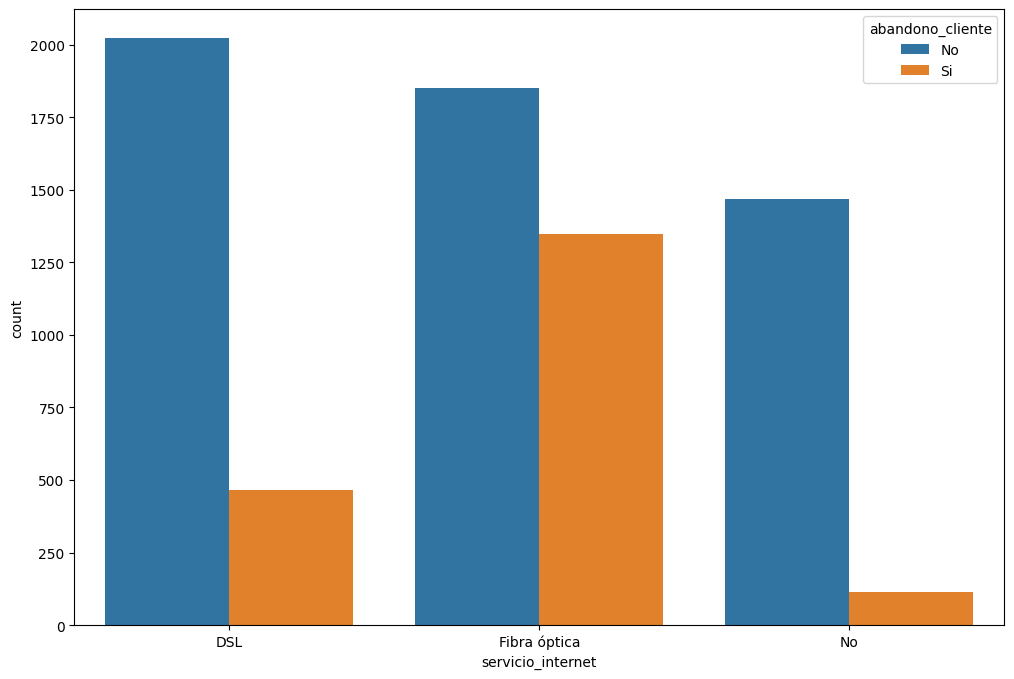

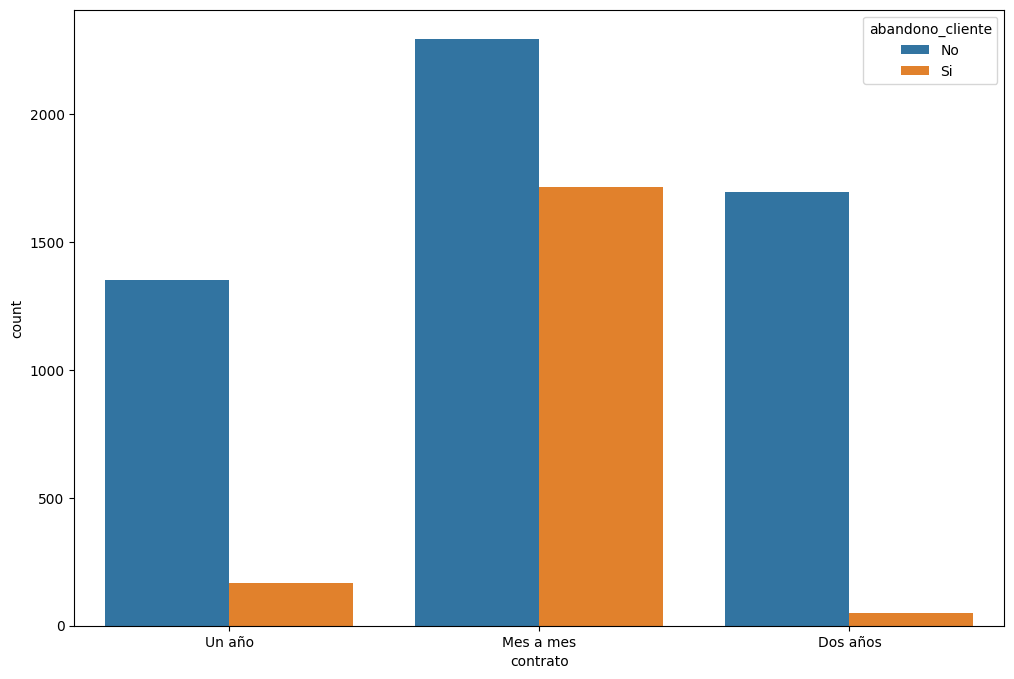

In [56]:
# Análisis categóricas
cat_cols = ['genero', 'servicio_internet', 'contrato']
for col in cat_cols:
    plt.figure(figsize=(12, 8))
    sns.countplot(x=col, hue='abandono_cliente', data=Df_base)

### Verificación de la Proporción de Cancelación (Churn)

Si deseas profundizar en el análisis, aplica técnicas de balanceo como **undersampling** o **oversampling**. En situaciones de fuerte desbalanceo, herramientas como **SMOTE** pueden ser útiles para generar ejemplos sintéticos de la clase minoritaria.

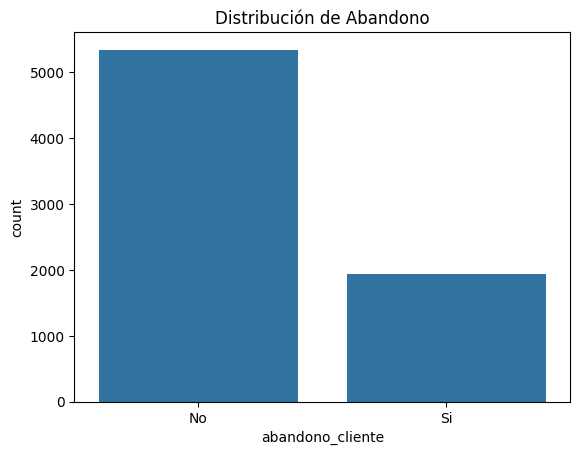

In [57]:
# Distribución de target
sns.countplot(x='abandono_cliente', data=Df_base)
plt.title('Distribución de Abandono');

In [58]:
print("Proporcion Cantidad:",Df_base['abandono_cliente'].value_counts())
print("Proporcion porcentaje:", Df_base['abandono_cliente'].value_counts(normalize=True).round(3)*100)

Proporcion Cantidad: abandono_cliente
No    5339
Si    1928
Name: count, dtype: int64
Proporcion porcentaje: abandono_cliente
No    73.5
Si    26.5
Name: proportion, dtype: float64


### Eliminación de Columnas Irrelevantes

Elimina columnas que **no aportan valor al análisis** o a **los modelos predictivos**, como identificadores únicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos.

In [59]:
Df_base.drop(columns=['id_cliente', 'cargo.diario'], axis=1,inplace=True)

**Eliminar columnas redundantes o problemáticas**

*   `id_cliente`: Identificador único sin valor predictivo.
*   `cargo.diario`: **Redundante**. Se calcula como `cargo.mensual / 30` (aproximado). No añade información única.



In [60]:
# Conversión de target
Df_base['abandono_cliente'] = Df_base['abandono_cliente'].map({'Si': 1, 'No': 0})

`abandono_cliente`:

*   Si: `1`
*   No: `0`




In [61]:
Df_base.tail(1)

,abandono_cliente,genero,jubilado,pareja,dependientes,meses_antiguedad,servicio_telefono,ad.multiples_lineas,servicio_internet,ad.seguridad_online,ad.respaldo_online,ad.proteccion_dispositivo,ad.soporte_tecnico,tv.streaming,peliculas.streaming,contrato,factura_digital,metodo_pago,cargo.mensual,cargo.total
7266,0,Masculino,False,Si,Si,63,No,Sin servicio telefónico,DSL,Si,Si,Si,No,Si,Si,Dos años,No,Cheque electrónico,59.0,3707.6


In [62]:
Df_base.columns

Index(['abandono_cliente', 'genero', 'jubilado', 'pareja', 'dependientes',
       'meses_antiguedad', 'servicio_telefono', 'ad.multiples_lineas',
       'servicio_internet', 'ad.seguridad_online', 'ad.respaldo_online',
       'ad.proteccion_dispositivo', 'ad.soporte_tecnico', 'tv.streaming',
       'peliculas.streaming', 'contrato', 'factura_digital', 'metodo_pago',
       'cargo.mensual', 'cargo.total'],
      dtype='object')

### División Train/Test (con variables categóricas)

*   `X` se usa para modelos no lineales (árboles, random forest, etc.)
*   `X_linear` se usa para modelos lineales (regresión logística, etc.) que requieren evitar multicolinealidad.

Modelo no lineal

Selección de features (X) y target (y):

In [63]:
# Dividir ANTES de transformaciones para evitar data leakage
X = Df_base.drop(columns=['abandono_cliente'], axis=1)
y = Df_base['abandono_cliente']

In [64]:
# Dividir datos en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Mantener proporción de clases
    random_state=42
)

In [65]:
# Identificar tipos de columnas
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

**Explicación de manejo de categóricas:**<br>
La división se hace con las variables categóricas originales porque:
1.   No introduce data leakage
2.   `train_test_split` puede manejar objetos/strings sin problemas
3.   Las transformaciones se aplicarán después solo al training set

Hace lo mismo solo que mas automatizado

```
  Categorias = ['genero', 'jubilado', 'pareja', 'dependientes', 'servicio_telefono',
                'ad.multiples_lineas', 'servicio_internet', 'ad.seguridad_online',
                'ad.respaldo_online', 'ad.proteccion_dispositivo', 'ad.soporte_tecnico',
                'tv.streaming', 'peliculas.streaming', 'contrato', 'factura_digital', 'metodo_pago',]
```

### Encoding

Transforma las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de _machine learning_. Utiliza un método de codificación adecuado, como **one-hot encoding**.

Transformadores (`make_column_transformer`)

In [66]:
label_encoder = LabelEncoder()

# Configurar preprocesador con make_column_transformer
preprocesador_one_hot = make_column_transformer(
      (OneHotEncoder(drop='if_binary'), categorical_cols),
      # drop='if_binary' ➝ elimina una categoría si hay solo dos (evita duplicados).
      remainder='passthrough',
      # remainder='passthrough' ➝ las columnas numéricas se dejan como están.
      sparse_threshold=0,
)

Aplicar los transformadores:

In [67]:
# Aplicar solo al training set
X_train_processed = preprocesador_one_hot.fit_transform(X_train)
X_test_processed = preprocesador_one_hot.transform(X_test)

y = label_encoder.fit_transform(y)

In [68]:
X_test_processed

array([[1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.3000e+01, 2.0400e+01,
        2.5165e+02],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.9550e+01,
        1.9550e+01],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.3000e+01, 2.0050e+01,
        6.6945e+02],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 5.2000e+01, 9.1250e+01,
        4.7383e+03],
       [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 7.0000e+01, 1.1300e+02,
        7.9876e+03],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 4.0000e+01, 5.6600e+01,
        2.3791e+03]])

Obtener nombres de columnas codificadas:

In [44]:
columnas = preprocesador_one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

Transformacion a Df

In [45]:
Df_Train = pd.DataFrame(X_train_processed, columns=columnas_encoded)
Df_Test = pd.DataFrame(X_test_processed, columns=columnas_encoded)
Df_Encoded = pd.concat([Df_Train, Df_Test], axis=0, ignore_index=True)
Df_Encoded.tail(1)

,genero_Masculino,jubilado_True,pareja_Si,dependientes_Si,servicio_telefono_Si,ad.multiples_lineas_No,ad.multiples_lineas_Si,ad.multiples_lineas_Sin servicio telefónico,servicio_internet_DSL,servicio_internet_Fibra óptica,...,contrato_Mes a mes,contrato_Un año,factura_digital_Si,metodo_pago_Cheque electrónico,metodo_pago_Cheque por correo,metodo_pago_Tarjeta de crédito (automática),metodo_pago_Transferencia bancaria (automática),meses_antiguedad,cargo.mensual,cargo.total
7266,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,56.6,2379.1


In [49]:
Df_No_lineal_y = pd.DataFrame(y, columns=['abandono_cliente_si'])
Df_No_lineal = pd.concat([Df_Encoded, Df_No_lineal_y], axis=1)
Df_No_lineal

,genero_Masculino,jubilado_True,pareja_Si,dependientes_Si,servicio_telefono_Si,ad.multiples_lineas_No,ad.multiples_lineas_Si,ad.multiples_lineas_Sin servicio telefónico,servicio_internet_DSL,servicio_internet_Fibra óptica,...,contrato_Un año,factura_digital_Si,metodo_pago_Cheque electrónico,metodo_pago_Cheque por correo,metodo_pago_Tarjeta de crédito (automática),metodo_pago_Transferencia bancaria (automática),meses_antiguedad,cargo.mensual,cargo.total,abandono_cliente_si
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,88.55,179.25,0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,82.30,214.40,0
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,21.0,96.80,2030.30,1
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,16.0,69.65,1043.30,1
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,35.0,73.45,2661.10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,61.0,101.15,6383.90,0
7263,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,12.0,89.40,1095.65,1
7264,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,52.0,91.25,4738.30,0
7265,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,70.0,113.00,7987.60,0


### Balanceo de Clases (opcional)

Si deseas profundizar en el análisis, aplica técnicas de balanceo como **undersampling** o **oversampling**. En situaciones de fuerte desbalanceo, herramientas como **SMOTE** pueden ser útiles para generar ejemplos sintéticos de la clase minoritaria.

Utilizamos (SMOTE)

In [290]:
# Aplicar SMOTE solo al conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_processed, y_train)

print("\nDistribución después de balanceo:")
print(pd.Series(y_train_bal).value_counts())


Distribución después de balanceo:
abandono_cliente
1    4271
0    4271
Name: count, dtype: int64


## 🎯 Correlación y Selección de Variables



### Análisis de Correlación

Visualiza la matriz de correlación para identificar relaciones entre las variables numéricas. Presta especial **atención a las variables que muestran una mayor correlación con la cancelación**, ya que estas pueden ser fuertes candidatas para el modelo predictivo.

### Análisis Dirigido

Investiga cómo variables específicas se relacionan con la cancelación, tales como:

- **Tiempo de contrato × Cancelación**
- **Gasto total × Cancelación**

Utiliza gráficos como **boxplots** o **scatter plots** para visualizar patrones y posibles tendencias.

### Análisis de Correlación (Post-balanceo)

### Normalización o Estandarización (si es necesario)

Evalúa la necesidad de normalizar o estandarizar los datos, según los modelos que se aplicarán. Modelos basados en distancia, como **KNN**, **SVM**, **Regresión Logística** y **Redes Neuronales**, requieren este preprocesamiento. Por otro lado, modelos basados en árboles, como **Decision Tree**, **Random Forest** y **XGBoost**, no son sensibles a la escala de los datos.

## 🤖 Modelado Predictivo



### Separación de Datos

Crea al menos dos modelos diferentes para predecir la cancelación de clientes.

- Un modelo puede requerir normalización, como **Regresión Logística** o **KNN**.
- El otro modelo puede no requerir normalización, como **Árbol de Decisión** o **Random Forest**.

💡 La decisión de aplicar o no la normalización depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalización, pero también es una opción combinar modelos con y sin normalización.

**Justificación:**

- **Regresión Logística / KNN:** Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.
- **Árbol de Decisión / Random Forest:** Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

Si decides normalizar los datos, deberías explicar cómo esta etapa asegura que los modelos basados en distancia o en optimización de parámetros no se vean sesgados por la magnitud de las variables.

### Creación de Modelos

Crea al menos dos modelos diferentes para predecir la cancelación de clientes.

- Un modelo puede requerir normalización, como **Regresión Logística** o **KNN**.
- El otro modelo puede no requerir normalización, como **Árbol de Decisión** o **Random Forest**.

💡 La decisión de aplicar o no la normalización depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalización, pero también es una opción combinar modelos con y sin normalización.

**Justificación:**

- **Regresión Logística / KNN:** Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.
- **Árbol de Decisión / Random Forest:** Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

Si decides normalizar los datos, deberías explicar cómo esta etapa asegura que los modelos basados en distancia o en optimización de parámetros no se vean sesgados por la magnitud de las variables.

### Evaluación de los Modelos

Evalúa cada modelo utilizando las siguientes métricas:

- **Exactitud (Acurácia)**
- **Precisión**
- **Recall**
- **F1-score**
- **Matriz de confusión**

Después, realiza un análisis crítico y compara los modelos:

- ¿Cuál modelo tuvo el mejor desempeño?
- ¿Algún modelo presentó **overfitting** o **underfitting**? Si es así, considera las posibles causas y ajustes:
  - **Overfitting**: Cuando el modelo aprende demasiado sobre los datos de entrenamiento, perdiendo la capacidad de generalizar a nuevos datos. Considera reducir la complejidad del modelo o aumentar los datos de entrenamiento.
  - **Underfitting**: Cuando el modelo no captura bien las tendencias de los datos, lo que indica que es demasiado simple. Intenta aumentar la complejidad del modelo o ajustar sus parámetros.

### Modelado y Evaluación

In [ ]:
# Entrenar modelo con datos balanceados
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

# Evaluar con test set original (sin balancear)
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)[:, 1]

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print(f"\nAUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1068
           1       0.59      0.48      0.53       386

    accuracy                           0.78      1454
   macro avg       0.71      0.68      0.69      1454
weighted avg       0.76      0.78      0.77      1454


AUC-ROC: 0.8238


## 📋 Interpretación y Conclusiones Datos



### Análisis de la Importancia de las Variables

Después de elegir los modelos, realiza el análisis de las variables más relevantes para la predicción de la cancelación:

* Regresión Logística: Investiga los coeficientes de las variables, que muestran su contribución a la predicción de cancelación.

* KNN (K-Nearest Neighbors): Observa cómo los vecinos más cercanos influyen en la decisión de clasificación. Las variables más impactantes pueden ser aquellas que más contribuyen a la proximidad entre los puntos de datos.

* Random Forest: Utiliza la importancia de las variables proporcionada por el modelo. Random Forest calcula la importancia basándose en cómo cada variable contribuye a la reducción de la impureza durante las divisiones de los árboles.

* SVM (Support Vector Machine): En el SVM, las variables más relevantes son aquellas que influyen en la frontera de decisión entre las clases. Puedes analizar los coeficientes de los vectores de soporte para entender qué variables tienen mayor impacto.

* Otros Modelos: Dependiendo del modelo elegido, considera el análisis de métricas específicas para comprender la relevancia de las variables. Por ejemplo, coeficientes en modelos lineales, pesos en redes neuronales, o la importancia relativa en técnicas de boosting (como XGBoost).

### Conclusión

Elaboren un informe detallado, destacando los factores que más influyen en la cancelación, basándose en las variables seleccionadas y en el rendimiento de cada modelo.

Identifiquen los principales factores que afectan la cancelación de clientes y propongan estrategias de retención basadas en los resultados obtenidos.